# Preprocessing Images for OCR

## 00. Opening an Image

In [3]:
import cv2
from matplotlib import pyplot as plt

image_file = "./data/page_01.jpg"
img = cv2.imread(image_file)
print("Image read into memory.")

Image read into memory.


### Helper function to display an image inline

In [4]:
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [5]:
# display(image_file)

## 01. Inverted Images

Inverting an image has to do with the inverting of pixels. White spectrum pixels will become black and vice-versa. 

Note: Inverting an image is not a critical/widely used step in Tesseract 4. In fact, results can be negatively affected. 

In [6]:
inverted_image = cv2.bitwise_not(img)
cv2.imwrite("./temp/inverted.jpg", inverted_image)

True

In [7]:
# display("./temp/inverted.jpg")

## 02. Rescaling

We rescale because there is an optimal range our file can live in for best OCR results.

This range is defined by the height of the characters; also knows as DPI (dots per inch). 

## 03. Binarization - CRITICAL STEP

The process of converting an image to black and white and increasing the contract between background and text. 

In order for an image to be converted to black and white well, it must first be in gray scale. 

This is a two step process:

    1. Process your image with a `grayscale` function.
    2. Run your image through the `cv2.threshold` function while manipulating threshold values.  

### Helper function to grayscale an image

In [8]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [9]:
gray_image = grayscale(image=img)
cv2.imwrite("./temp/gray.jpg", gray_image)

True

Often, the `cv2.threshold` values will start at 127 and 255 but with text, this is not always the best parameters to star with. 

For faded images of text, start with 200 and 230.

In [10]:
thresh, im_bw = cv2.threshold(gray_image, 200, 230, cv2.THRESH_BINARY)
cv2.imwrite("./temp/bw_image.jpg", im_bw)

True

## O3. Noise Removal

In [11]:
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

In [12]:
no_noise = noise_removal(im_bw)
cv2.imwrite("./temp/no_noise.png", no_noise)

True

## 05. Dilation and Erosion

This process is used to adjust font size and is to be implemented after noise is taken out of the image. 

Note: Dilation and Erosion are both meant to handle black background images with white text; so inversion MUST be performed before calling this function. Otherwise, we will get opposite results. 

The actual text erosion is most affected via the `kernel` variable so testing should begin here. Increase/Decrease to get desired results. 

In [13]:
def thin_font(image):
    import numpy as np
    inverted_image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    eroded_image = cv2.erode(inverted_image, kernel, iterations=1)
    image = cv2.bitwise_not(eroded_image)
    return (image)

In [14]:
eroded_image = thin_font(no_noise)
cv2.imwrite("./temp/eroded_img.png", eroded_image)

True

In [15]:
def thick_font(image):
    import numpy as np
    inverted_image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    dilated_image = cv2.dilate(inverted_image, kernel, iterations=1)
    image = cv2.bitwise_not(dilated_image)
    return (image)

In [16]:
dilated_image = thick_font(no_noise)
cv2.imwrite("./temp/dilated_image.jpg", dilated_image)

True

## 06: Rotation / Deskewing

Pre-reqs needed before rotating/deskewing:

    1. Text must be vertically aligned and in a horizontal straight line. 
    2. Image cannot have a border. 


### Helper function to rotate and deskew an image. 

In [20]:
#https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
"""
    This function at a high level captures the angle of text and determines the best adjustment to rotate.

    Returns:
        _type_: _description_
"""
import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [21]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [22]:
new = cv2.imread("./data/page_01_rotated.JPG")
fixed = deskew(new)
cv2.imwrite("./temp/rotated_fixed.jpg", fixed)

28


True

## 07. Removing Borders

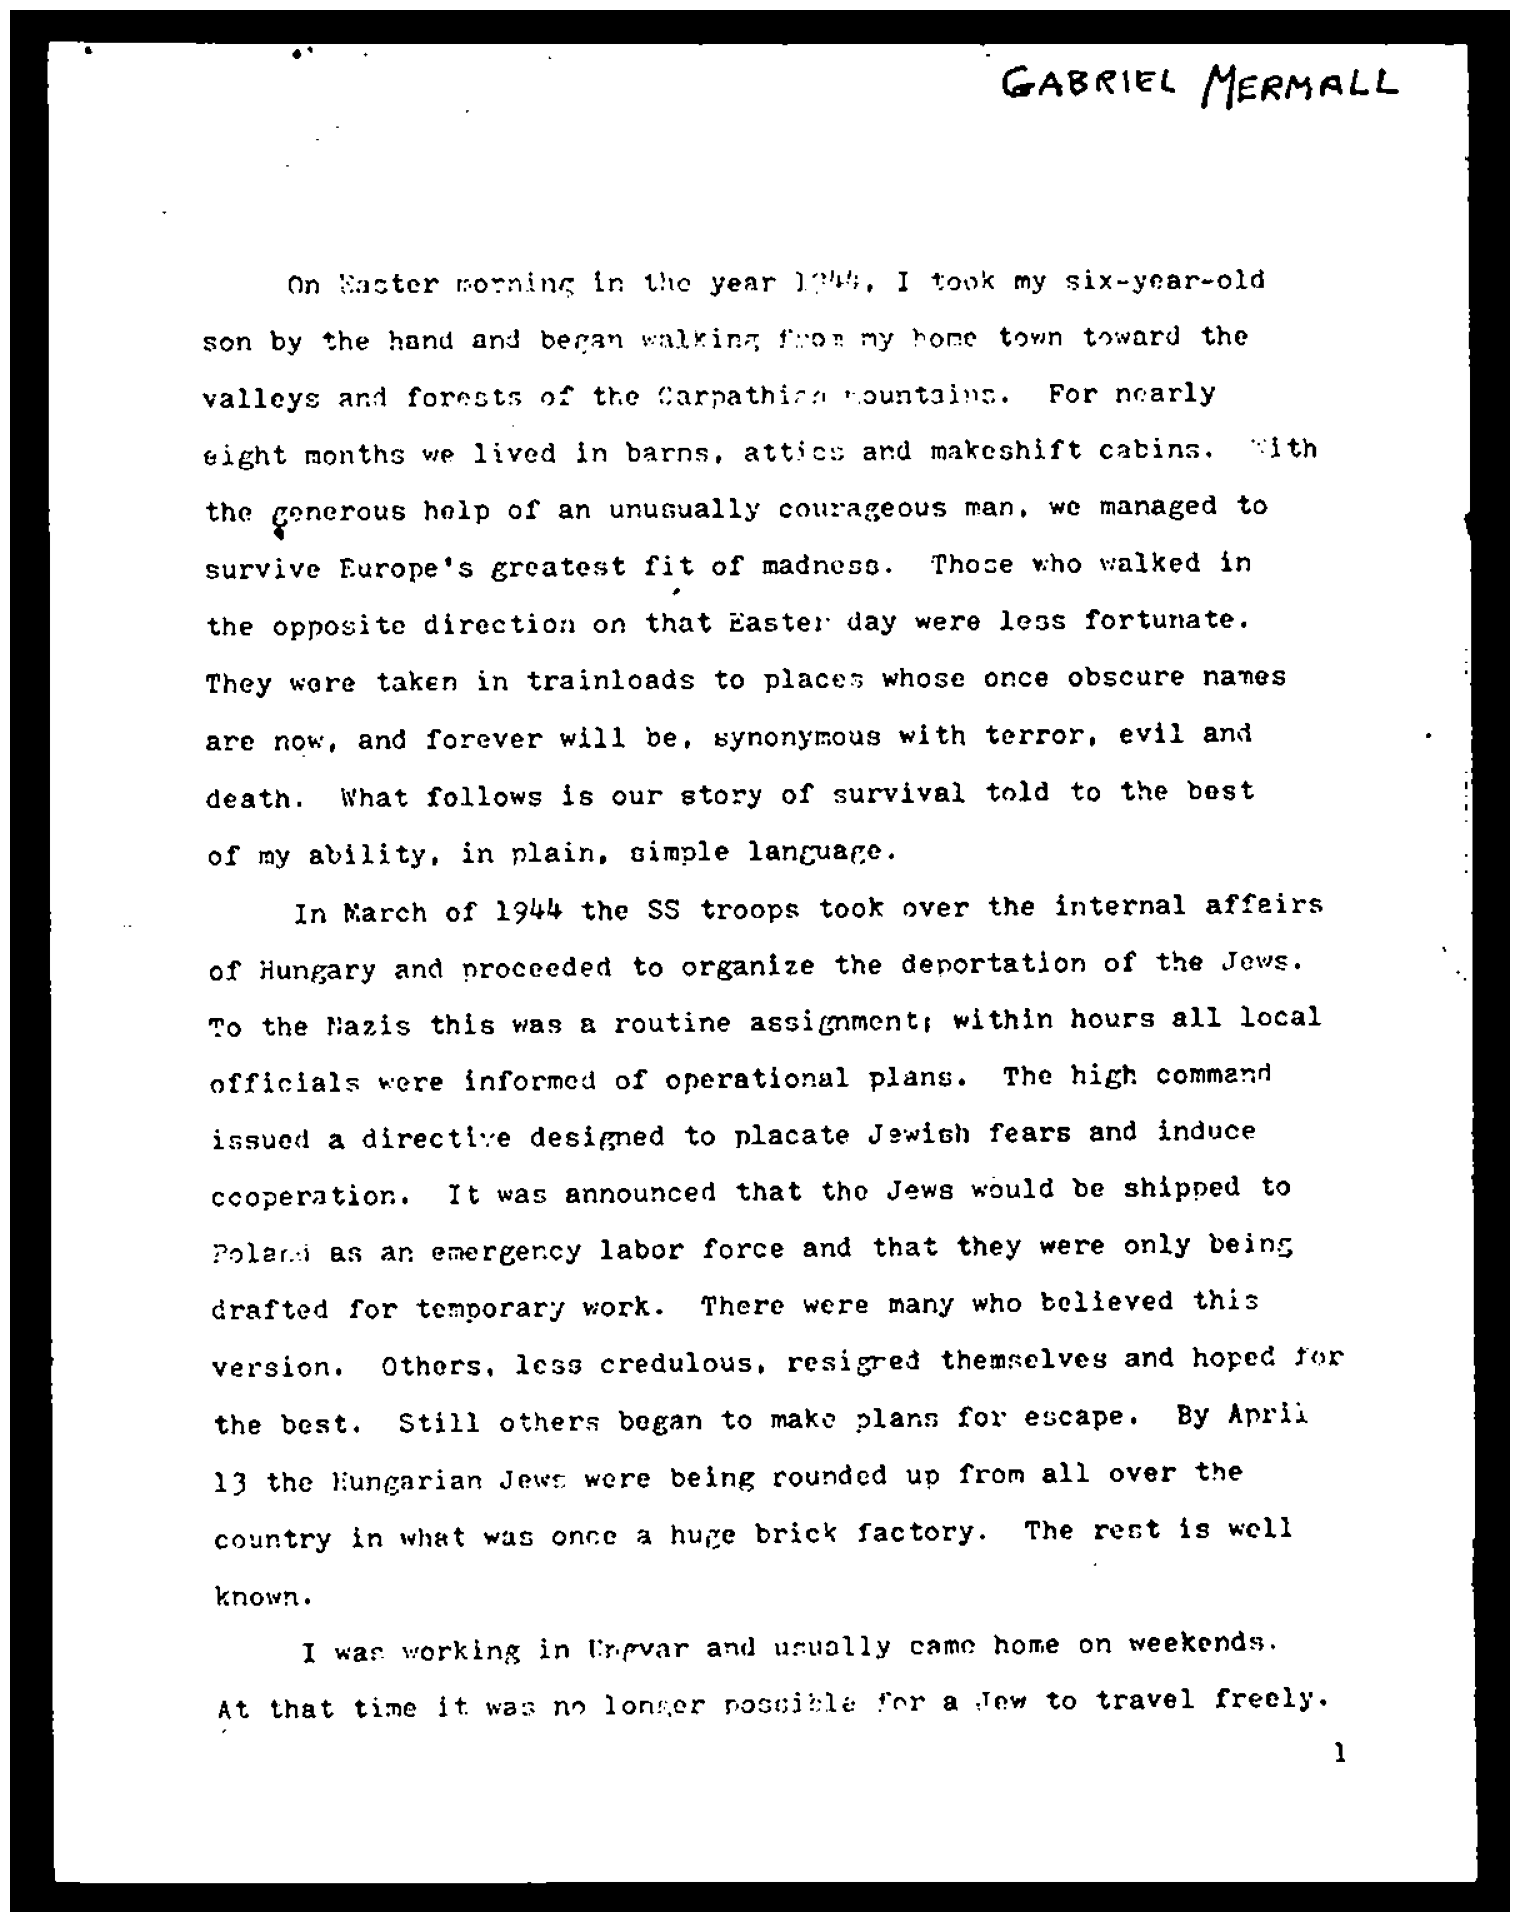

In [23]:
display("./temp/no_noise.png")

In [24]:
def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

In [26]:
no_borders = remove_borders(no_noise)
cv2.imwrite("./temp/no_borders.jpg", no_borders)
# display('./temp/no_borders.jpg')

True

## 08.Adding Borders

We need to add borders because by default, the models were trained with some borders.

In [28]:
# border color = white RGB code
color = [255, 255, 255]
# border array
top, bottom, left, right = [150]*4

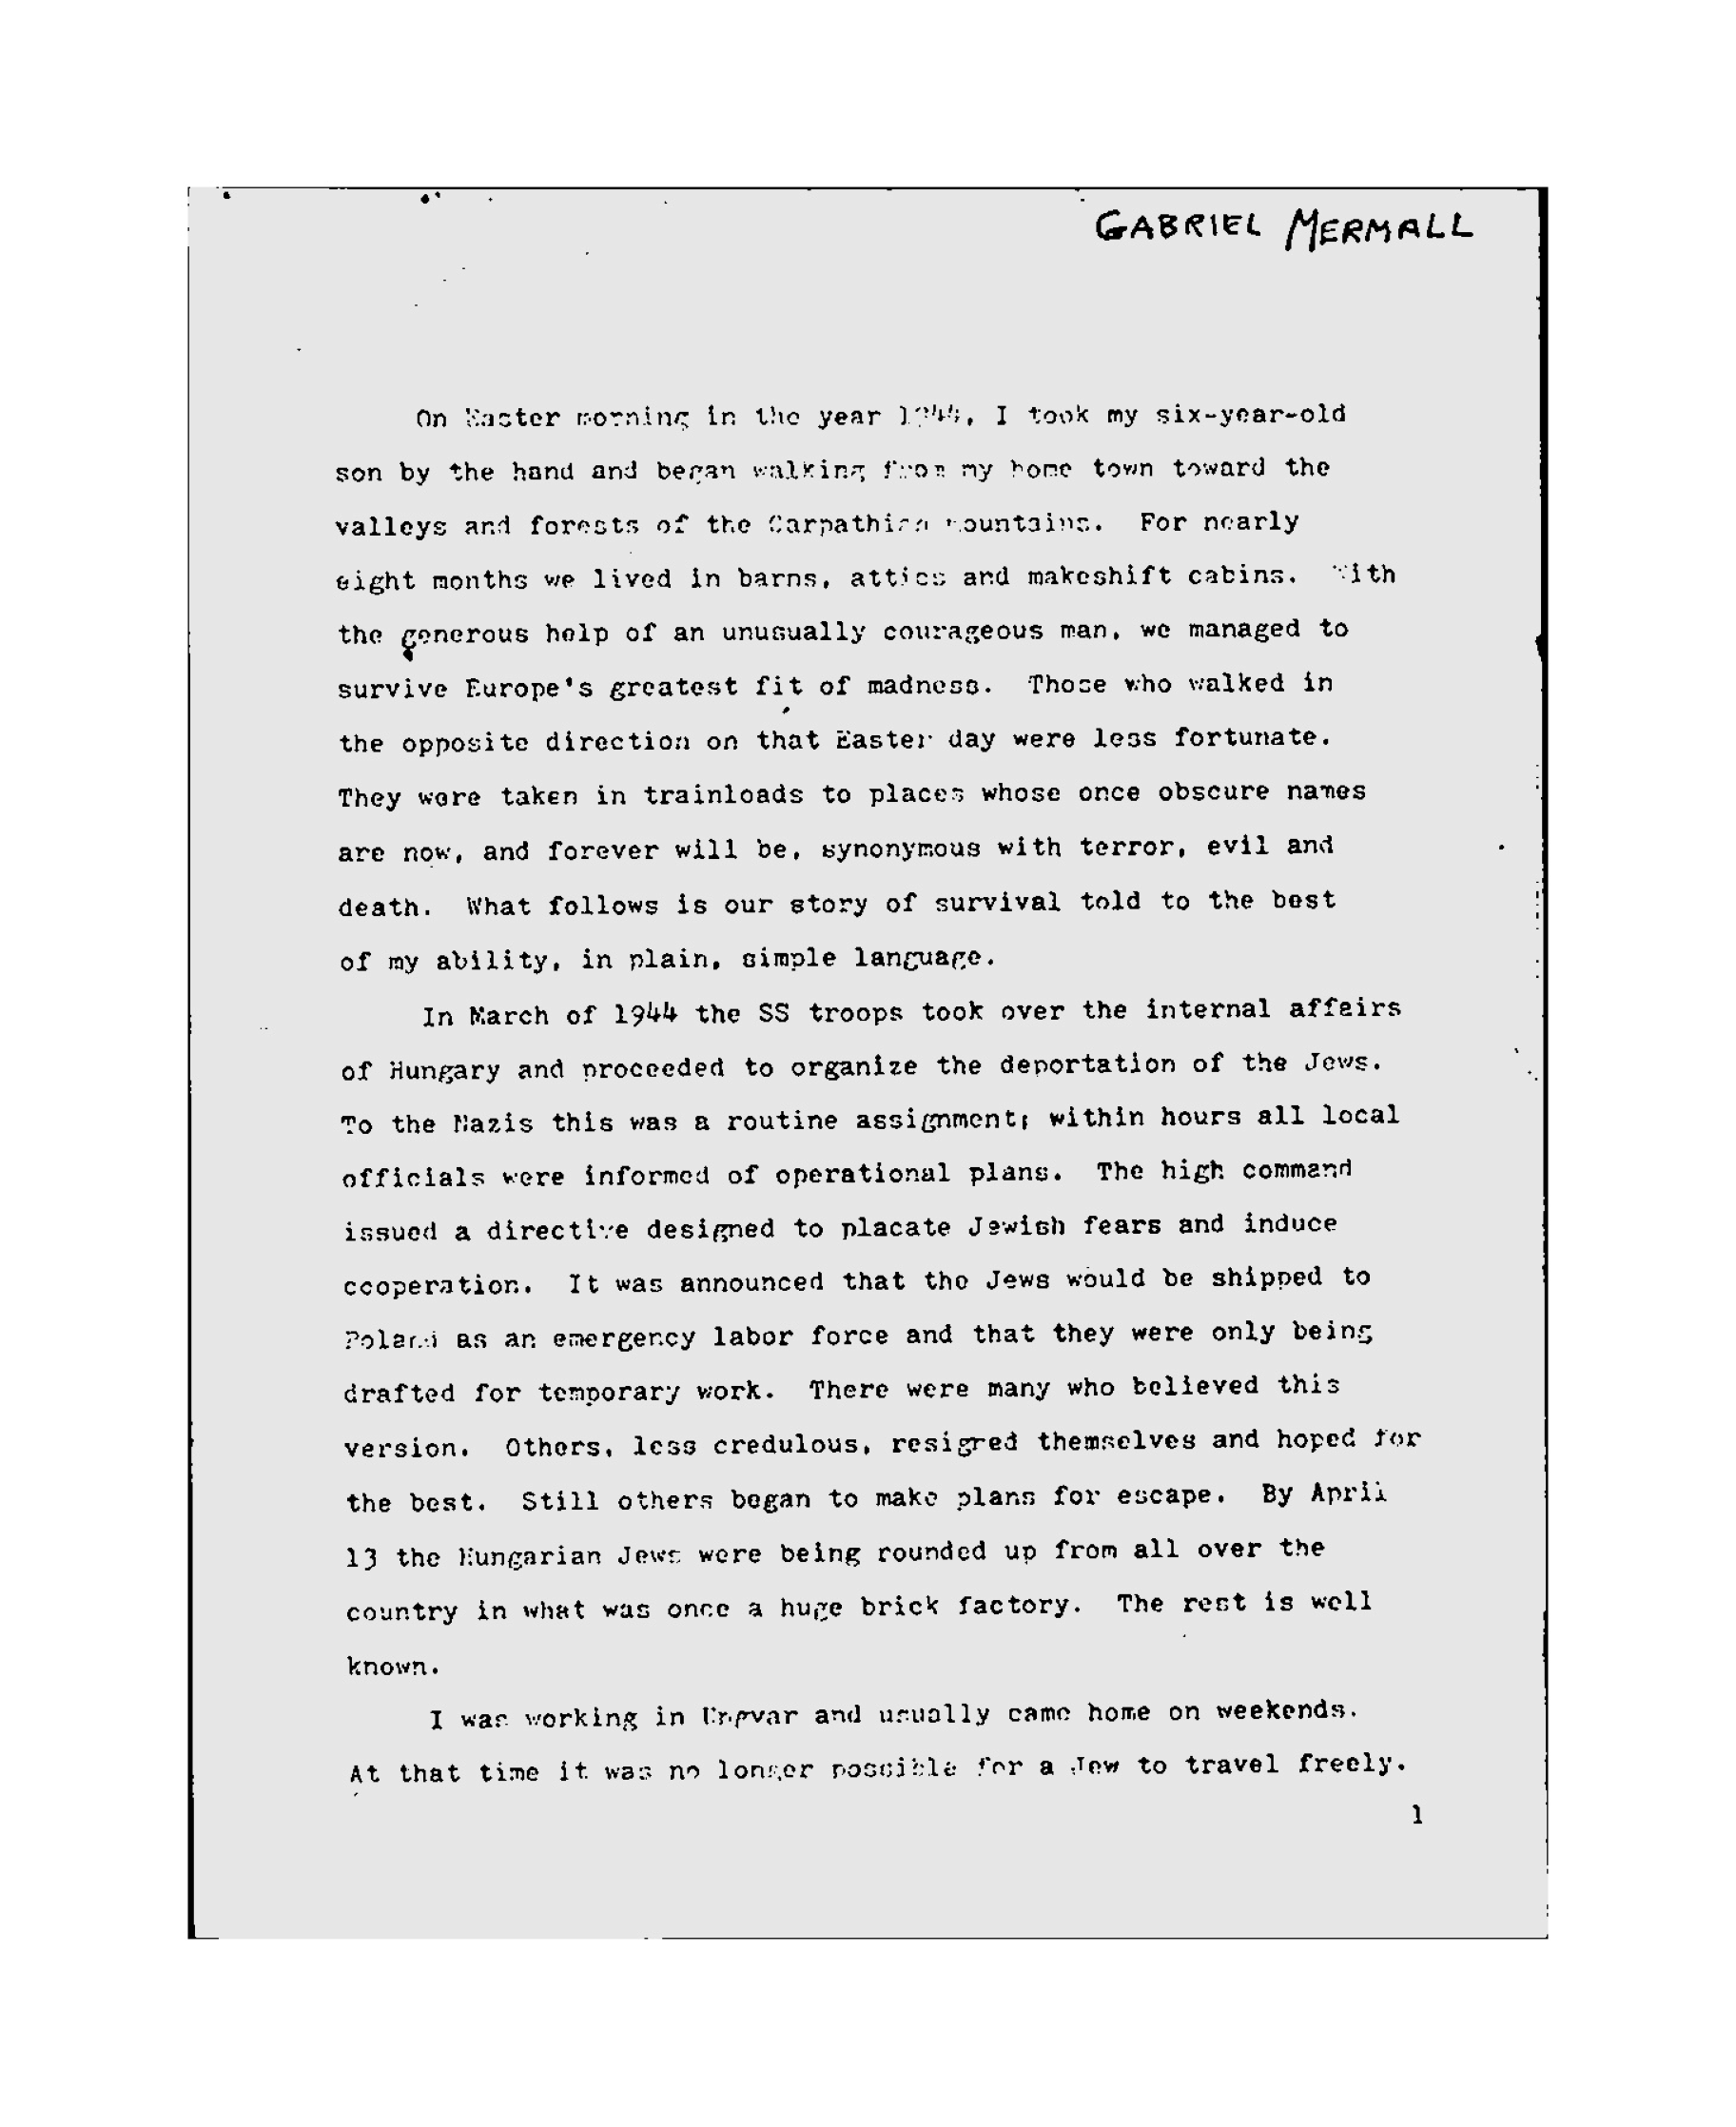

In [29]:
image_with_border = cv2.copyMakeBorder(no_borders, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
cv2.imwrite("./temp/image_with_border.jpg", image_with_border)
display("./temp/image_with_border.jpg")